In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# from utils import *

pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 16, 'lines.linewidth': 2.5})

In [3]:
def get_df(file, header=None):
    df = pd.read_csv(file, header=None) # header=None可明确使用传入的数据为header
    # df.columns = DF_HEADER.get(key, df.columns)
    # 从header文件中拿header并设置
    df.columns = pd.read_csv("{}.header".format(file.split('.csv')[0])).columns if header is None else header
    return df

DATA_DIR = './data/'
dfj = get_df(DATA_DIR + 'pai_job_table.csv')
dft = get_df(DATA_DIR + 'pai_task_table.csv')
dfi = get_df(DATA_DIR + 'pai_instance_table.csv')
dfs = get_df(DATA_DIR + 'pai_sensor_table.csv')
dfg = get_df(DATA_DIR + 'pai_group_tag_table.csv')
dfp = get_df(DATA_DIR + 'pai_machine_spec.csv')
dfm = get_df(DATA_DIR + 'pai_machine_metric.csv')

In [4]:
def get_dfia(dfi):
    dfi_s = dfi[dfi.start_time > 0][['job_name','task_name','start_time']].groupby(['job_name','task_name']).min()  # start_time
    dfi_e = dfi[dfi.end_time > 0][['job_name','task_name','end_time']].groupby(['job_name','task_name']).max()  # end_time
    dfi_m = dfi[(dfi.start_time > 0) & (dfi.end_time > 0)][['job_name','task_name','end_time','start_time']]
    dfi_m['runtime'] = dfi_m.end_time-dfi_m.start_time
    dfi_m = dfi_m.groupby(['job_name','task_name']).mean()[['runtime']].reset_index() # runtime
    dfi_u = dfi[['job_name','task_name','status']].drop_duplicates().groupby(['job_name','task_name']).max() # status
    dfia = dfi_u
    for df in [dfi_s, dfi_e, dfi_m]:
        dfia = dfia.merge(df, on=['job_name','task_name'], how='left')
    return dfia

def get_dfa(dft, dfj, dfi, dfg):
    print('dft + dfj ...')
    dfa = dft.merge(dfj, on=['job_name'], suffixes = ['','_j'])
    dfa.loc[dfa.start_time==0, 'start_time'] = np.nan
    dfa.loc[dfa.start_time==0, 'end_time'] = np.nan
    dfa['runtime'] = dfa.end_time - dfa.start_time
    print('dft + dfj + dfi ...')
    dfia = get_dfia(dfi)
    dfa = dfa.merge(dfia, on=['job_name','task_name'], suffixes=['','_i'])
    dfa['duration_min'] = dfa.runtime_i / 60  # duration of instances
    dfa['wait_time'] = dfa.start_time_i - dfa.start_time # task wait time
    dfa['start_date']=dfa.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai') # task start time
    # dfa = dfa[dfa.status=='Terminated']
    print('dft + dfj + dfi + dfg ...')
    dfa = dfa.merge(dfg[[x for x in dfg.columns if x != 'user']], on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfa.loc[dfa.group.isnull(),'group'] = dfa.loc[dfa.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfa

dfa = get_dfa(dft, dfj, dfi, dfg)       # dfa: dataframe of task


dft + dfj ...
dft + dfj + dfi ...
dft + dfj + dfi + dfg ...


In [5]:
dfa.head(5)

,job_name,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,inst_id,user,status_j,start_time_j,end_time_j,runtime,status_i,start_time_i,end_time_i,runtime_i,duration_min,wait_time,start_date,gpu_type_spec,group,workload
0,c936346f45eccd34bf748541,tensorflow,1.0,Terminated,2693235.0,2695847.0,600.0,29.296875,50.0,MISC,990f1799a5093b62142b101c0227875b81c7f0329301df98af1148ec8724,58540f191766,Terminated,2693235.0,2695847.0,2612.0,Terminated,2693240.0,2695847.0,2607.0,43.450000,5.0,1970-02-01 12:07:15+08:00,NaN,31c5b7fa71e1224f9dff5c5a4d24b571,NaN
1,455c3dec270f4777ad67721c,tensorflow,1.0,Terminated,3399583.0,3399732.0,600.0,29.296875,100.0,MISC,d94b4b01a6dd6c1865972cd628abe206422143ef37e6d449d4b2e862e574,ebba56ec23b9,Terminated,3399583.0,3399732.0,149.0,Terminated,3399681.0,3399732.0,51.0,0.850000,98.0,1970-02-09 16:19:43+08:00,NaN,5a3163d07db392e47b6f0d063906592f,NaN
2,ba64aa2f0feff18428923e92,tensorflow,1.0,Terminated,2152271.0,2158213.0,600.0,29.296875,50.0,MISC,af71dfe31db0378561e1bea2c26605f67cb7611f0d38661b43881a1c6006,de69ddc1064e,Terminated,2152271.0,2158213.0,5942.0,Terminated,2152280.0,2158213.0,5933.0,98.883333,9.0,1970-01-26 05:51:11+08:00,NaN,f94dcf2c0efdf3fd36f75dbe1709c43f,NaN
3,704783be2a4b7f88b8d2e4ee,worker,100.0,Failed,2172980.0,NaN,600.0,9.765625,10.0,MISC,a63da076c1210109040acf759e2c1d00b8abc2d84305990a5941d0142690,cfcb2e0deb93,Failed,2172974.0,2173216.0,NaN,Interrupted,2172995.0,NaN,NaN,NaN,15.0,1970-01-26 11:36:20+08:00,NaN,e933ce21ede6be61f206b69b225f9a4a,NaN
4,704783be2a4b7f88b8d2e4ee,ps,10.0,Running,2172974.0,2173216.0,600.0,19.531250,NaN,NaN,a63da076c1210109040acf759e2c1d00b8abc2d84305990a5941d0142690,cfcb2e0deb93,Failed,2172974.0,2173216.0,242.0,Running,NaN,NaN,NaN,NaN,NaN,1970-01-26 11:36:14+08:00,NaN,e933ce21ede6be61f206b69b225f9a4a,NaN


In [6]:
def get_dfiw(dfi):
    dfiw = dfi.sort_values(['status','start_time','end_time'])
    dfiw.drop_duplicates(subset=['worker_name'], keep='last', inplace=True)
    dfiw.dropna(subset=['worker_name'], inplace=True)
    dfiw['runtime'] = dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['end_time'] \
                    - dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['start_time']
    dfiw.loc[dfiw.start_time==0, 'start_time'] = np.nan
    dfiw.loc[dfiw.start_time==0, 'end_time'] = np.nan
    return dfiw

def get_dfw(dfi, dft, dfg):
    dfw = get_dfiw(dfi)
    dfw['start_date']=dfw.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai')
    print('dfi + dft ...')
    dfw = dfw.merge(dft, on=['job_name','task_name'], how='left', suffixes=['', '_t'])
    print('dfi + dft + dfg ...')
    dfw = dfw.merge(dfg, on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfw.loc[dfw.group.isnull(),'group'] = dfw.loc[dfw.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfw

dfw = get_dfw(dfi, dft, dfg)       # dfw: dataframe of work

dfi + dft ...
dfi + dft + dfg ...


In [7]:
dfw.head(5)

,job_name,task_name,inst_name,worker_name,inst_id,status,start_time,end_time,machine,runtime,start_date,inst_num,status_t,start_time_t,end_time_t,plan_cpu,plan_mem,plan_gpu,gpu_type,user,gpu_type_spec,group,workload
0,31fe7a4e1565891f332f2b33,tensorflow,d3a2559f812a514b69832da5e024ca4a58be3acddd039c37f00bdd6ea646,7d677a8af756946d7e2d4ed024eb65475d0092361d7cb75f38f5431f4f82,4770ab9a93f5b311b629c66cfaa40ca41fb4485548b3375031d4167ed3cf,Failed,494366.0,NaN,34c2506b0fd012a7ba49cb71,NaN,1970-01-07 01:19:26+08:00,1.0,Failed,494319.0,NaN,600.0,29.296875,25.0,MISC,NaN,NaN,NaN,NaN
1,6be512ebc1890951ef8fe9a3,tensorflow,384cbee69562ef92e218b63f6a727a0d3f241bb4291665046810378b2cca,1e36d66d9b37bc0c82ee24a62af03f1176cf45f790e5a74ece2f58ab6671,ce060ae257ddd9e6e3118c75ae95d3b8896da466eb9fe932d89ca4fdd9cc,Failed,494377.0,NaN,95dd4e457bd5b15e593a160b,NaN,1970-01-07 01:19:37+08:00,1.0,Failed,494326.0,NaN,600.0,29.296875,25.0,MISC,NaN,NaN,NaN,NaN
2,418cf3def0eaa3389c8c743f,tensorflow,e014a607da9e552cedfa9cf26415240a12519bc2e40a86adb82af46d8f80,ae1854573395f140f7899065ac39421173cb76ef095c7a4549f151453d49,187346e2a6bb3ce2dfec8bb9dcb237c8e1cf4de3b4bcb0d3ee0a4e486e0b,Failed,516013.0,NaN,142a829a1e344f905fdcce42,NaN,1970-01-07 07:20:13+08:00,1.0,Failed,516002.0,NaN,600.0,29.296875,25.0,MISC,NaN,NaN,NaN,NaN
3,6ad04e6d3dd2c35e3a0c3e5f,tensorflow,a5b51ba177c9f11e1dc3b0e9fdc3b4bc9d2f3587c79bf3ac7a5e1efa2fd0,c5fdf47e3c0cd90f9411da1f4e5ed9310f5d078755951f24a3b7258ca2fd,9ef5598f518e76f7dd9a33fd55bbd00416f97b012ea83ce53de8ea12d974,Failed,516104.0,NaN,1a22c7040e090510e29bc619,NaN,1970-01-07 07:21:44+08:00,1.0,Failed,516023.0,NaN,600.0,29.296875,25.0,V100,NaN,NaN,NaN,NaN
4,193e6fdd5cb271f54d85f739,ps,78389d332aa67368c06bf7958c42a78ba4fb0667679327be2b8ef31c5614,b5627309306d0d68bee8edf6cf65c81f44fe87ed92a9f3d0da77c89c8e1a,b150d2eccab57c9539f8ba1c3804c37e5532e681dc7d0ac82d7eb964eb72,Failed,531747.0,NaN,9f75e9b83f6d914a91317c75,NaN,1970-01-07 11:42:27+08:00,1.0,Failed,531744.0,NaN,600.0,29.296875,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# dfws: dataframe of worker with sersor data
dfws = dfw.merge(dfp.drop(columns={'gpu_type'}), on='machine', how='left')
dfws = dfws.merge(dfs.drop(columns=['job_name','task_name','inst_id','machine']), on='worker_name')

In [20]:
dfws.head(5)
dfws.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3019349 entries, 0 to 3019348
Data columns (total 37 columns):
 #   Column           Dtype                        
---  ------           -----                        
 0   job_name         object                       
 1   task_name        object                       
 2   inst_name        object                       
 3   worker_name      object                       
 4   inst_id          object                       
 5   status           object                       
 6   start_time       float64                      
 7   end_time         float64                      
 8   machine          object                       
 9   runtime          float64                      
 10  start_date       datetime64[ns, Asia/Shanghai]
 11  inst_num         float64                      
 12  status_t         object                       
 13  start_time_t     float64                      
 14  end_time_t       float64                      
 15

In [10]:
# dfas: dataframe of task with sensor data
dfas = dfws.groupby(['job_name','task_name'])[['cpu_usage','gpu_wrk_util','avg_mem','avg_gpu_wrk_mem','plan_cpu','plan_gpu','plan_mem','cap_cpu','cap_gpu','cap_mem']].sum()
dfas = dfa.drop(columns=['plan_cpu','plan_mem','plan_gpu']).merge(dfas, on=['job_name','task_name'])

In [18]:
dfas.head(20)
dfas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850033 entries, 0 to 850032
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype                        
---  ------           --------------   -----                        
 0   job_name         850033 non-null  object                       
 1   task_name        850033 non-null  object                       
 2   inst_num         850033 non-null  float64                      
 3   status           850033 non-null  object                       
 4   start_time       850033 non-null  float64                      
 5   end_time         591075 non-null  float64                      
 6   gpu_type         850032 non-null  object                       
 7   inst_id          850033 non-null  object                       
 8   user             850033 non-null  object                       
 9   status_j         850033 non-null  object                       
 10  start_time_j     850020 non-null  float64               

<Figure size 480x360 with 0 Axes>

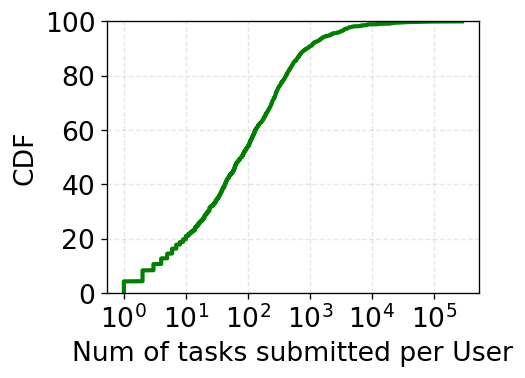

In [12]:
def get_cdf(data, inverse=False):
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data))/(len(sorted_data)-1)
    p = 100. - p if inverse else p # CCDF
    return sorted_data, p

def plot_data_cdf(data, inverse=False, datalabel=None, xlabel=None, title=None, xlog=False, xlim=None, ylog=False, xticks=None, figsize=(4,3), dpi=120, savefig=None, ylabel=None):
    plt.figure(figsize=figsize, dpi=dpi)
    if type(data) == pd.DataFrame:
        data.dropna(inplace=True)
    x, y = get_cdf(data, inverse)
    plt.plot(x, y, label=datalabel, color='green', linestyle='-')
    if datalabel is not None: plt.legend(loc='lower right')
    if xlog: plt.xscale('log')
    if ylog: plt.yscale('log')
    if xlim is not None: plt.xlim(xlim)
    plt.ylim(0, 100)
    if xlabel is not None: plt.xlabel(xlabel)
    plt.ylabel(ylabel) if ylabel is not None else plt.ylabel('CCDF') if inverse is True else plt.ylabel('CDF')
    if title is not None: plt.title(title)
    if xticks is not None: plt.xticks(xticks)
    plt.grid(alpha=.3, linestyle='--')
    if savefig is not None:
        plt.savefig('/tmp/figures/{}.pdf'.format(savefig),bbox_inches='tight')
    else:
        plt.show()

user_task_count = dfa.groupby('user').count()[['job_name']]

plt.figure(figsize=(4,3), dpi=120)
plot_data_cdf(user_task_count['job_name'], xlog=True,
              ylabel='CDF',xlabel='Num of tasks submitted per User',
              xticks=[1,10,100,10**3,10**4,10**5])

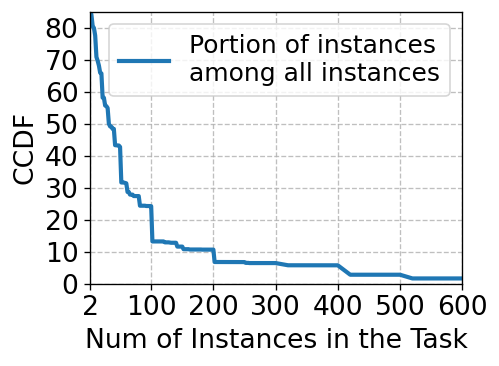

In [13]:
def get_inst_task_num_ratio(dfa, inst_num_list=[2, 8, 20, 64, 100, 256, 512]):
    total_num_task, total_num_inst = len(dfa), sum(dfa['inst_num'])
    data_df = []
    for i in inst_num_list:
        temp_df = dfa[dfa['inst_num'] >= i]
        task_num_ratio = len(temp_df) / total_num_task
        inst_num_ratio = sum(temp_df['inst_num']) / total_num_inst
        data_df.append([task_num_ratio, inst_num_ratio])
    out_df = pd.DataFrame(data_df, columns=['num_task_ratio','num_inst_ratio'])
    out_df = out_df.T.rename(columns=dict(zip(range(len(inst_num_list)), inst_num_list)))
    return out_df

inst_num_list = list(range(2, 300, 2))+list(range(300, 620, 20))
inst_task_num_ratio_df = get_inst_task_num_ratio(dfa, inst_num_list) * 100

plt.figure(figsize=(4,3), dpi=120)
plt.plot(inst_task_num_ratio_df.T.num_inst_ratio, label='Portion of instances\namong all instances')
plt.grid(alpha=0.8, linestyle='--')
plt.xlabel('Num of Instances in the Task')
plt.ylabel('CCDF')
plt.xticks((2,100,200,300,400,500,600))
plt.yticks([0,10,20,30,40,50,60,70,80])
plt.xlim(2, 600)
plt.ylim(0, 85)
plt.legend(fontsize=15)

Hour 0 Date: 1970-01-25 00:00:03+08:00


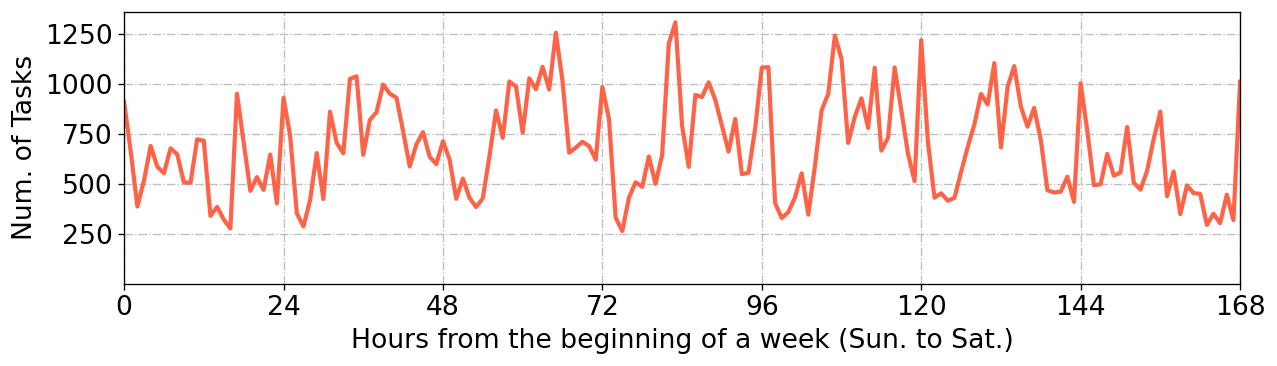

In [14]:
# 任务提交时间模式
offset = -600
dfa['hourofyear'] = dfa.start_date.apply(lambda c: c.dayofyear * 24 + c.hour)
dftcc = dfa.groupby('hourofyear').count()[['job_name']].reset_index()
dftcc['hour'] = dftcc.hourofyear + offset
print('Hour 0 Date: {}'.format(dfa[dfa.hourofyear==-offset].start_date.min()))

plt.figure(figsize=(12,3), dpi=120)
num_days = 7
plt.plot(dftcc[(dftcc.hour>=0)&(dftcc.hour<24*num_days+1)].set_index('hour')[['job_name']], color='tomato')
plt.xlabel('Hours from the beginning of a week (Sun. to Sat.)')
plt.ylabel('Num. of Tasks')
plt.grid(alpha=0.8, linestyle='-.')
plt.xlim(0, 24*num_days)
plt.ylim(0, )
plt.yticks([250,500,750,1000,1250])
_ = plt.xticks([24 * x for x in range(num_days+1)])
# plt.savefig('/tmp/figures/{}.pdf'.format('diurnal-pattern-task'),bbox_inches='tight')

C:\Users\zonglin\AppData\Local\Temp/ipykernel_3084/2411868571.py:22: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  for date in sorted(df.date.unique()):


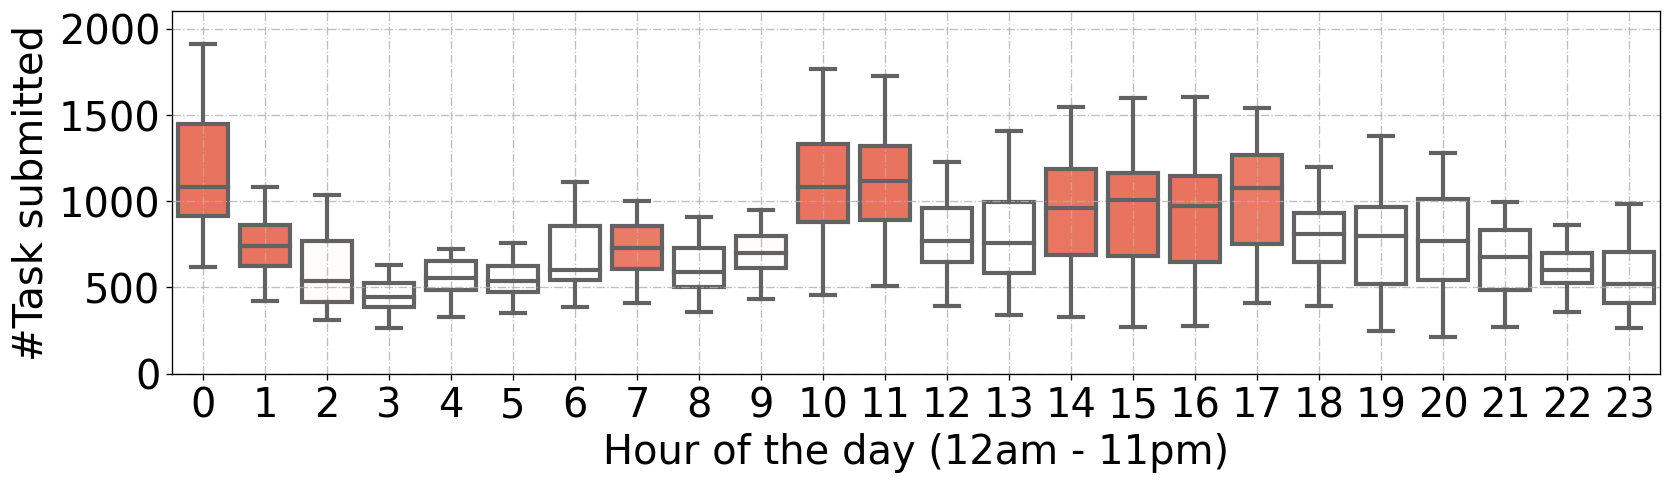

In [15]:
# 一天内不同时间任务提交的数量
def add_hour_date(df):
    if 'start_date' not in df:
        if 'start_time_t' in df:
            target_col = 'start_time_t'
        elif 'start_time' in df:
            target_col = 'start_time'
        else:
            print('start_time, start_time_t, dayofyear unfound in df')
            return None
        df['start_date'] = df[target_col].apply(lambda x: pd.Timestamp(x, unit='s', tz='Asia/Shanghai'))
    if 'date' not in df:
        df['date'] = df['start_date'].apply(lambda x: x.date())
    if 'hour' not in df:
        df['hour'] = df['start_date'].apply(lambda x: x.hour)
    return df

def get_hourly_task_request(df): # df = dftjkix
    sum_df_list = []
    df = add_hour_date(df.copy())
    # for day in sorted(df.dayofyear.unique()):
    for date in sorted(df.date.unique()):
        # tempdf = df[df.dayofyear==day]
        tempdf = df[df.date==date]
        res_df = tempdf.groupby('hour').count()[['job_name']]
        res_df.rename(columns={'job_name':date}, inplace=True)
        sum_df_list.append(res_df.T)
    out_df = pd.DataFrame().append(sum_df_list)
    return out_df.dropna() # if a day contains hours of NaN, it is not a typical day

hourly_task = get_hourly_task_request(dfa)
hourly_task_data_df = pd.melt(hourly_task, 
    value_vars=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
hourly_task_data_df['hour'] = hourly_task_data_df['hour'].astype('int')

matplotlib.rcParams.update({"font.size": 24})
plt.figure(figsize=(16,4), dpi=120)
highlight_color = 'tomato'
mean_value = hourly_task_data_df.value.mean()
color_df = pd.DataFrame(hourly_task_data_df.groupby('hour').mean())
color_df['color'] = color_df.value.apply(lambda x: '1' if x < mean_value else highlight_color)
color_df['mean_value'] = mean_value
color_palette = sns.blend_palette(color_df.color.tolist(), n_colors=24)

g = sns.boxplot(data=hourly_task_data_df, x='hour', y='value', whis=1, fliersize=0, palette=color_palette)
g.set(ylim=(0, 2100))
g.set(xlabel='Hour of the day (12am - 11pm)')
g.set(ylabel='#Task submitted')
plt.yticks([0,500,1000,1500,2000])
plt.grid(alpha=0.8, linestyle='-.')
matplotlib.rcParams.update({"font.size": 16})
# plt.savefig('/tmp/figures/{}.pdf'.format('overview-task_submission_hourly'),bbox_inches='tight')

Hour 0 Date: 1970-01-25 00:00:03+08:00


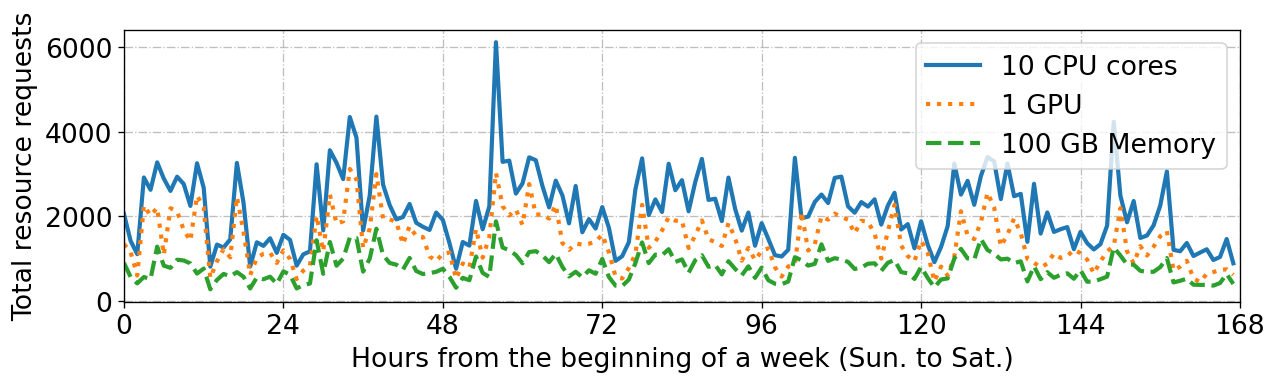

In [16]:
dfw['hourofyear'] = dfw.start_date.apply(lambda c: c.dayofyear * 24 + c.hour)
dfitcr = dfw.groupby('hourofyear').sum()[['plan_cpu','plan_gpu','plan_mem']].reset_index()
dfitcr['hour'] = dfitcr.hourofyear + offset
print('Hour 0 Date: {}'.format(dfa[dfa.hourofyear==-offset].start_date.min()))

plt.figure(figsize=(12,3), dpi=120)
num_days = 7
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_cpu']/1000, label='10 CPU cores', linestyle='solid')
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_gpu']/100, label='1 GPU', linestyle='dotted')
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_mem']/100, label='100 GB Memory', linestyle='dashed')
plt.xlabel('Hours from the beginning of a week (Sun. to Sat.)')
plt.ylabel('Total resource requests')
plt.grid(alpha=0.8, linestyle='-.')
plt.legend(ncol=1, loc='best')
plt.xlim(0, 24*num_days)
_ = plt.xticks([24 * x for x in range(num_days+1)])

C:\Users\zonglin\AppData\Local\Temp/ipykernel_3084/2725320272.py:13: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  for date in sorted(df.date.unique()):


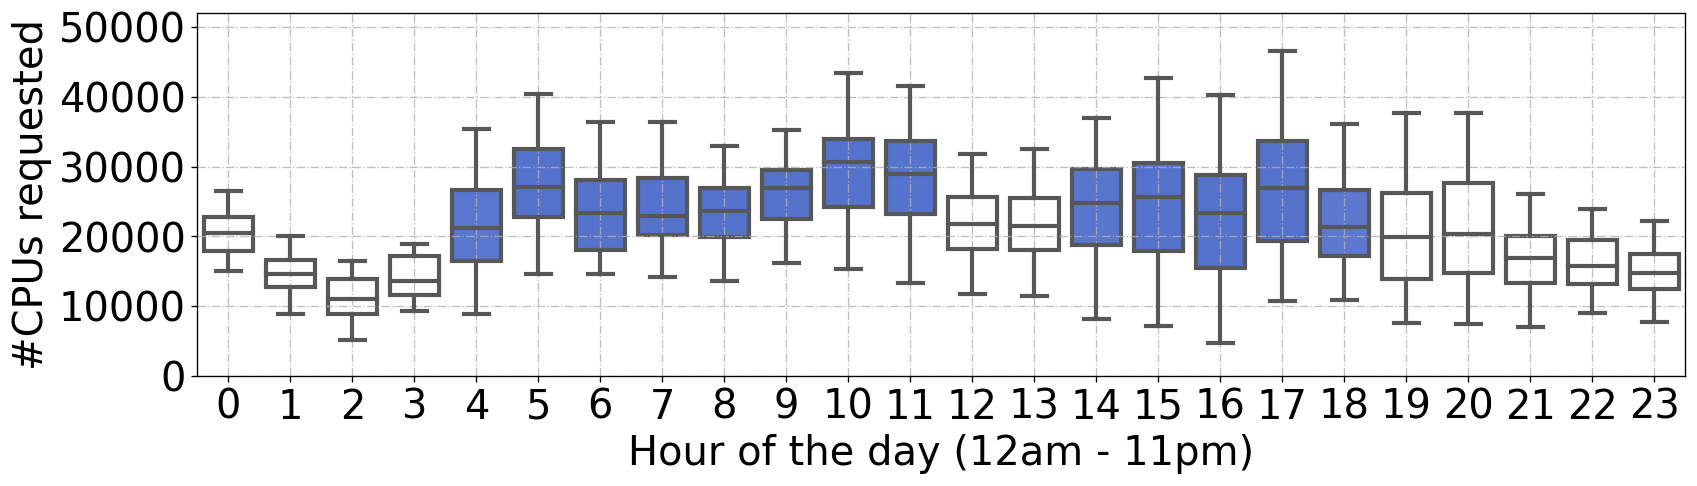

In [17]:
def get_hourly_task_resource_request(df, metrics='cpu'): # df = dftjkix
    sum_df_list = []
    df = add_hour_date(df)
    if metrics == 'cpu':
        df['plan_resource'] = df.plan_cpu.apply(lambda x: x/100)
    elif metrics == 'gpu':
        df['plan_resource'] = df.plan_gpu.apply(lambda x: x/100)
    elif metrics == 'mem':
        df['plan_resource'] = df.plan_mem.apply(lambda x: x/1000)
    else:
        exit()
    # for day in sorted(df.dayofyear.unique()):
    for date in sorted(df.date.unique()):
        # tempdf = df[df.dayofyear==day]
        tempdf = df[df.date==date]
        res_df = tempdf.groupby('hour').sum()[['plan_resource']]
        res_df.rename(columns={'job_name':date}, inplace=True)
        sum_df_list.append(res_df.T)
    out_df = pd.DataFrame().append(sum_df_list)
    return out_df.dropna() # if a day contains hours of NaN, it is not a typical day

plan_cpu_df = get_hourly_task_resource_request(dfw.dropna(subset=['job_name']), metrics='cpu')
plan_cpu_data_df = pd.melt(plan_cpu_df, 
    value_vars=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
plan_cpu_data_df['hour'] = plan_cpu_data_df['hour'].astype('int')

matplotlib.rcParams.update({"font.size": 24})
plt.figure(figsize=(16,4), dpi=120)
highlight_color = 'royalblue'
mean_value = plan_cpu_data_df.value.mean()
color_df = pd.DataFrame(plan_cpu_data_df.groupby('hour').mean())
color_df['color'] = color_df.value.apply(lambda x: '1' if x < mean_value else highlight_color)
color_palette = sns.blend_palette(color_df.color.tolist(), n_colors=24)

g = sns.boxplot(data=plan_cpu_data_df, x='hour', y='value', whis=1, fliersize=0, palette=color_palette)
g.set(ylim=(0, 52000))
g.set(xlabel='Hour of the day (12am - 11pm)')
g.set(ylabel='#CPUs requested')
plt.grid(alpha=0.8, linestyle='-.')
matplotlib.rcParams.update({"font.size": 16})
# plt.savefig('/tmp/figures/{}.pdf'.format('overview-cpu_request_hourly'),bbox_inches='tight')